In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
%matplotlib inline

D:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Preprocessing and Analysing

In [2]:
import pandas as pd
df_initial = pd.read_excel("./digikala_customers.xlsx")
print("numner of entities : " + str(len(df_initial)))
df_initial.head()

numner of entities : 200000


,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
0,2714054,469662,21386,2015-10-15 08:50:56,597982,محمود آباد,1
1,11104039,3063877,248497,2018-02-11 00:29:26,980000,خرمدره,1
2,4228130,3184893,50144,2016-06-14 00:30:08,229358,قرچک,1
3,22225624,6888562,70208,2018-09-03 14:37:19,16514,قم,1
4,4068771,2533490,67627,2016-05-21 11:51:02,133028,تهران,1


In [3]:
bkp = df_initial

### Null Values

In [4]:

# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item
column type,int64,int64,int64,datetime64[ns],int64,object,int64
null values (nb),0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0


### Duplicate Records

In [5]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 0


### Analysing

In [6]:
df_initial.nunique()

ID_Order                 197631
ID_Customer              151634
ID_Item                   95232
DateTime_CartFinalize    197293
Amount_Gross_Order        22416
city_name_fa                906
Quantity_item                44
dtype: int64

In [7]:
df_initial.describe()

,ID_Order,ID_Customer,ID_Item,Amount_Gross_Order,Quantity_item
count,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,200000.000000
mean,9.871963e+06,2.860671e+06,3.757313e+05,1.458204e+06,1.261225
std,6.404275e+06,1.921815e+06,3.948462e+05,5.450972e+06,1.801186
min,1.000411e+06,4.661320e+05,7.600000e+01,0.000000e+00,1.000000
25%,5.022253e+06,1.021053e+06,8.955725e+04,1.212730e+05,1.000000
50%,8.591270e+06,2.895180e+06,2.302210e+05,3.211010e+05,1.000000
75%,1.246037e+07,4.179218e+06,5.192668e+05,1.011032e+06,1.000000
max,2.484656e+07,7.282118e+06,2.093722e+06,1.530000e+09,500.000000


In [8]:
print('Top 10 total price of each invoice')
df_initial['TotalPrice'] = df_initial['Quantity_item'] * df_initial['Amount_Gross_Order']
df_initial.sort_values('TotalPrice', ascending=False)[:10]

Top 10 total price of each invoice


,ID_Order,ID_Customer,ID_Item,DateTime_CartFinalize,Amount_Gross_Order,city_name_fa,Quantity_item,TotalPrice
32036,8556100,643657,428330,2017-09-13 14:53:22,1530000000,تهران,1,1530000000
189646,1122141,716378,12206,2014-02-19 13:25:00,11882452,تهران,30,356473560
123282,9925599,5437450,303009,2017-12-11 23:22:13,19990826,تهران,14,279871564
102923,6616927,3656845,241665,2017-03-04 12:52:42,26487156,تهران,8,211897248
71671,5908757,838763,242471,2016-12-28 16:12:55,35796734,تهران,5,178983670
85948,7763049,4257021,316879,2017-07-04 21:56:57,177000000,بروجرد,1,177000000
63339,6000172,1244742,247402,2017-01-07 10:07:11,3119266,یزد,54,168440364
20687,13137692,6960541,449189,2018-05-26 10:26:22,166623853,تهران,1,166623853
14407,23449403,7131218,975414,2018-10-21 13:40:36,158990000,تهران,1,158990000
72747,10580826,1018240,306698,2018-01-13 16:38:46,157699000,تهران,1,157699000


In [9]:
from datetime import datetime, date, time
PRESENT = datetime(2018,12,30)
df_initial['DateTime_CartFinalize'] = pd.to_datetime(df_initial['DateTime_CartFinalize'])
rfmTable= df_initial.groupby('ID_Customer').agg({'DateTime_CartFinalize': lambda date: (PRESENT - date.max()).days,
                                        'ID_Order': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})
rfmTable1= df_initial.groupby('ID_Customer').agg({'DateTime_CartFinalize': lambda date: (PRESENT - date.min()).days})

In [10]:
TrfmTable = rfmTable.copy()
TrfmTable.columns=['recency','frequency','monetary']
rfmTable1.columns=['days']
# TrfmTable.frequency = TrfmTable.frequency / (rfmTable1.days)
# TrfmTable.frequency = (TrfmTable.frequency) / TrfmTable.frequency.std()

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler.fit(TrfmTable)
normal = scaler.fit_transform(TrfmTable[['frequency','monetary','recency']])


In [12]:
TrfmTable.frequency = normal[:,0]
TrfmTable.monetary = normal[:,1]
TrfmTable.recency = normal[:,2]

In [13]:
TrfmTable.describe()

,recency,frequency,monetary
count,151634.000000,151634.000000,151634.000000
mean,0.268268,0.002141,0.001362
std,0.203777,0.006833,0.004802
min,0.000000,0.000000,0.000000
25%,0.110468,0.000000,0.000124
50%,0.211468,0.000000,0.000359
75%,0.393477,0.000000,0.001078
max,1.000000,1.000000,1.000000


# Features Correlation

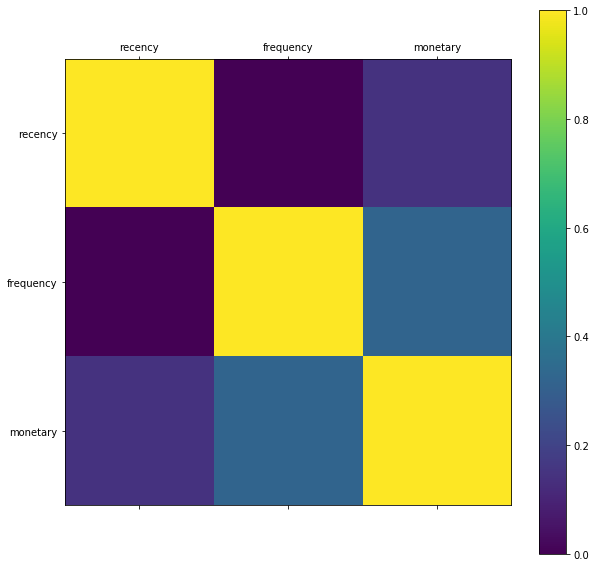

In [14]:
corr_df = TrfmTable
corr = corr_df.corr()
size = 10
fig, ax = plt.subplots(figsize=(size, size))
cax = ax.matshow(corr_df, interpolation='nearest')
ax.matshow(corr)
fig.colorbar(cax)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

# Clustring with K-Means

In [15]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(TrfmTable)
    wcss.append(kmeans.inertia_)

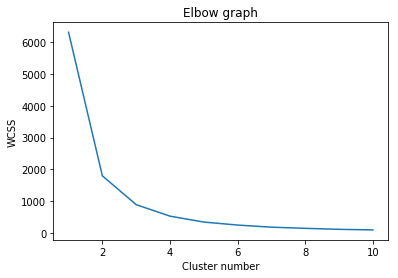

In [16]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(TrfmTable)

In [22]:
TrfmTable['clusters'] = clusters
TrfmTable.head()

,recency,frequency,monetary,clusters
ID_Customer,,,,
466132,0.004734,0.067114,0.023164,0
466136,0.234087,0.000000,0.000201,1
466141,0.335613,0.013423,0.000865,2
466146,0.538664,0.000000,0.000198,2
466152,0.052078,0.013423,0.000767,0


Text(0.5,0,'Monetary')

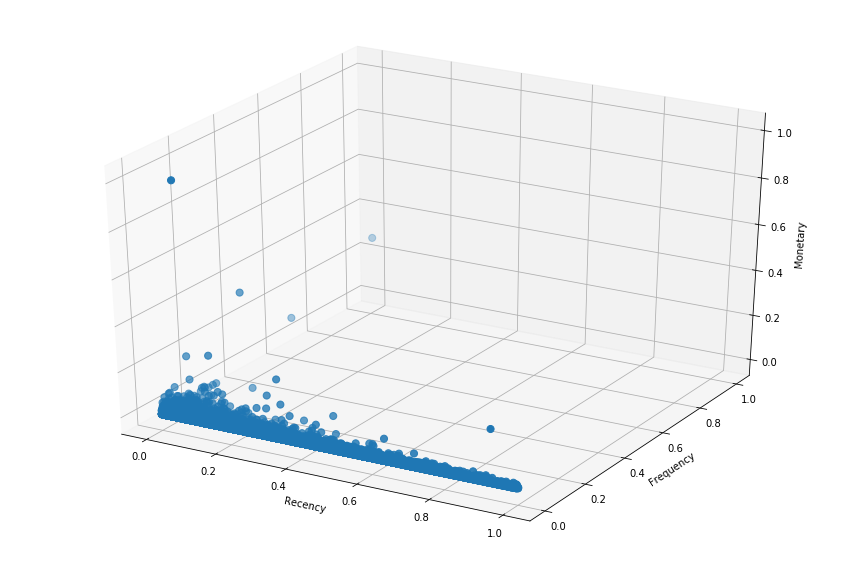

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(TrfmTable.recency, TrfmTable.frequency, TrfmTable.monetary, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

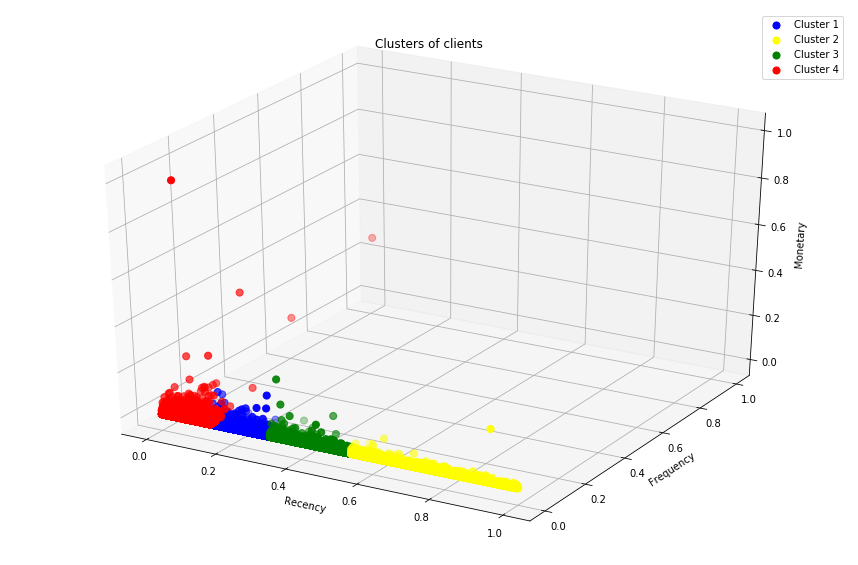

In [265]:

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(TrfmTable[TrfmTable.clusters == i].recency, 
               TrfmTable[TrfmTable.clusters == i].frequency, 
               TrfmTable[TrfmTable.clusters == i].monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

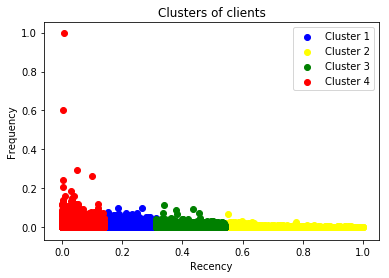

In [268]:

c1 = TrfmTable[TrfmTable.clusters == 0]
c2 = TrfmTable[TrfmTable.clusters == 1]
c3 = TrfmTable[TrfmTable.clusters == 2]
c4 = TrfmTable[TrfmTable.clusters == 3]

plt.scatter(c1.recency, c1.frequency, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.recency, c2.frequency, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.recency, c3.frequency, c = 'green', label = 'Cluster 3')
plt.scatter(c4.recency, c4.frequency, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

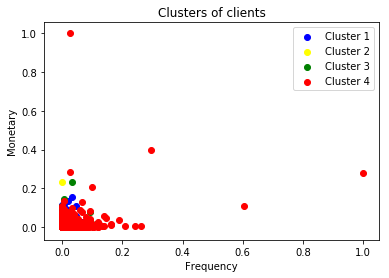

In [269]:
c1 = TrfmTable[TrfmTable.clusters == 0]
c2 = TrfmTable[TrfmTable.clusters == 1]
c3 = TrfmTable[TrfmTable.clusters == 2]
c4 = TrfmTable[TrfmTable.clusters == 3]

plt.scatter(c1.frequency, c1.monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.frequency, c2.monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.frequency, c3.monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.frequency, c4.monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

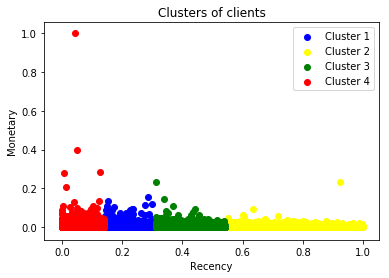

In [270]:

c1 = TrfmTable[TrfmTable.clusters == 0]
c2 = TrfmTable[TrfmTable.clusters == 1]
c3 = TrfmTable[TrfmTable.clusters == 2]
c4 = TrfmTable[TrfmTable.clusters == 3]

plt.scatter(c1.recency, c1.monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.recency, c2.monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.recency, c3.monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.recency, c4.monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

In [27]:
clusterResult = TrfmTable.groupby('clusters').agg({'clusters': lambda num: len(num)})

In [28]:
clusterResult.head()

,clusters
clusters,
0,48933
1,49263
2,34706
3,18732
